In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorboard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [80]:
print("gpu uygundur" if tf.config.list_physical_devices("GPU") else "nothing")

gpu uygundur


In [169]:
def pather(is_test=False):
    if is_test==False:
        path="C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train"
        file_list = ['C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train/'+f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]  
    else:
        path="C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/test/test1"
        file_list = ['C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/test/test1/'+f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    return path,file_list

In [170]:
path,file_list=pather()

In [171]:
breeds=[]
for f in os.listdir(path):
    breeds.append(f[:3])

In [172]:
file_list

['C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train/cat.0.jpg',
 'C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train/cat.1.jpg',
 'C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train/cat.10.jpg',
 'C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train/cat.100.jpg',
 'C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train/cat.1000.jpg',
 'C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train/cat.10000.jpg',
 'C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train/cat.10001.jpg',
 'C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train/cat.10002.jpg',
 'C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train/cat.10003.jpg',
 'C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train/cat.10004.jpg',
 'C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/train/cat.10005.jpg',
 '

In [173]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)


In [174]:
#boolean_label=[label==np.unique(breeds) for label in breeds]

In [175]:
boolean_label=pd.get_dummies(breeds).to_numpy()

In [176]:
IMG_SIZE=224
class image_processes:
    def ___init__(self):
        pass
    def image_process(self,image_path, img_size=IMG_SIZE):
      """
      Takes an image file path and turns the image into a Tensor.
      """
      # Read in an image file
      image=tf.io.read_file(image_path)
      image=tf.image.decode_jpeg(image,channels=3)
      image=tf.image.convert_image_dtype(image,tf.float32)
      image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])
    
      return image       # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    
    def image_process_for_valids(self,image,label):
        image=self.image_process(image)
        return image,label
    
    def image_batcher(self,x,y=None,batch_size=32,is_valid=False,is_test=False):
        if is_test:
            print("Creting test batch")
            data=tf.data.Dataset.from_tensor_slices(tf.constant(x))
            data=data.map(self.image_process)
            data_batch=data.batch(batch_size)
            return data_batch
        elif is_valid:
            print("Creating validation batch")
            data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
            data=data.map(self.image_process_for_valids)
            data_batch=data.batch(batch_size)
            return data_batch
        else:
            print("Creating train batch")
            data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
            data=data.shuffle(buffer_size=len(x))
            data=data.map(self.image_process_for_valids)
            data_batch=data.batch(batch_size)
            return data_batch

In [177]:
x=file_list
y=boolean_label

In [178]:
train_data=image_processes().image_batcher(x,y)


Creating train batch


## MODEL FITTING PROCESSES

In [179]:
INPUT_SHAPE=[None,IMG_SIZE,IMG_SIZE,3]

OUTPUT_SHAPE=len(np.unique(breeds))

MODEL_URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [182]:
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow as tf
import datetime
import os
class model__processes:
    def __init(self):
        pass
    def lr_schedule(self,epoch, lr):
        # Örneğin, her 10 epoch'ta öğrenme hızını yarıya indiriyoruz
        if epoch % 10 == 0 and epoch:
            return lr * 0.5
        return lr
        
    def create_model(self,input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
        print("Building model with : ", model_url)
       
        # Veri artırma katmanlarını ekleme
        """data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.1),
        ])"""
    
        # Model katmanlarını ayarlama
        model = tf.keras.Sequential([
            #data_augmentation,  # Veri artırma katmanı
            hub.KerasLayer(model_url),  # Önceden eğitilmiş model
            tf.keras.layers.Dense(units=output_shape, activation="sigmoid")  # Çıkış katmanı
        ])
        model.add(tf.keras.layers.Dropout(0.5))
    
        # Modeli derleme
        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),  # İkili sınıflandırma için uygun
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=["accuracy"]
        )
        model.build(input_shape)
        return model
    def create_tensorboard_callback(self):
        # Create a log directory for storing TensorBoard logs
        logdir = os.path.join("C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/logs",
                                # Make it so the logs get tracked whenever we run an experiment
                            datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        return tf.keras.callbacks.TensorBoard(logdir)
    def early_stopping_for_valids(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)
        return early_stopping
    def early_stopping_for_test(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                  patience=3)
        return early_stopping
        
    def train_model_w_valid(self,epoch=100):
         model=self.create_model()
         callbac=self.create_tensorboard_callback()
         #lir=tf.keras.callbacks.LearningRateScheduler(self.lr_schedule)
         model.fit(x=train_data,epochs=epoch,validation_data=valid_Data,validation_freq=1,callbacks=[callbac,self.early_stopping_for_valids()])
         return model
    def train_model_f_test(self,epoch=100):
         model=self.create_model()
         callbac=self.create_tensorboard_callback()
         #lir=tf.keras.callbacks.LearningRateScheduler(self.lr_schedule)
         model.fit(x=train_data,epochs=NUM_EPOCHS,callbacks=[callbac,self.early_stopping_for_test()])
         return model

In [183]:
model=model__processes().train_model_f_test()


Building model with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
782/782 [==============================] - 36s 42ms/step - loss: 3.9313 - accuracy: 0.6171
Epoch 2/100
782/782 [==============================] - 33s 42ms/step - loss: 3.9210 - accuracy: 0.6214
Epoch 3/100
782/782 [==============================] - 38s 49ms/step - loss: 3.9457 - accuracy: 0.6210
Epoch 4/100
782/782 [==============================] - 39s 50ms/step - loss: 3.8884 - accuracy: 0.6243
Epoch 5/100
782/782 [==============================] - 40s 51ms/step - loss: 3.8859 - accuracy: 0.6248
Epoch 6/100
782/782 [==============================] - 39s 49ms/step - loss: 3.8895 - accuracy: 0.6244
Epoch 7/100
782/782 [==============================] - 39s 50ms/step - loss: 3.9342 - accuracy: 0.6192
Epoch 8/100
782/782 [==============================] - 39s 49ms/step - loss: 3.9238 - accuracy: 0.6178


In [39]:

def model_unbatchify(train_data):
    images=[]
    labels=[]
    for image,label in train_data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(label)

    return images,labels


In [40]:
unbatch_images,unbatch_labels=model_unbatchify(valid_Data)


'cat'

In [99]:
def image_comparinger(model_pred_y=model_pred_y,valid_images=unbatch_images,valid_labels=unbatch_labels,n=0):
    pred_breed=np.unique(breeds)[model_pred_y[n].argmax()]
    true_image=valid_images[n]
    true_label=np.unique(breeds)[valid_labels[n].argmax()]
    plt.figure(figsize=[10,10])
    plt.subplot()
    plt.imshow(true_image)
    print(pred_breed)
    print(true_label)
    if pred_breed == true_label:
        color="green"
    else:
        color="red"
    plt.title("{} / {} % / {}".format(pred_breed,int(np.max(model_pred_y[n])*10**2),true_label),color=color)
    plt.show()

cat
cat


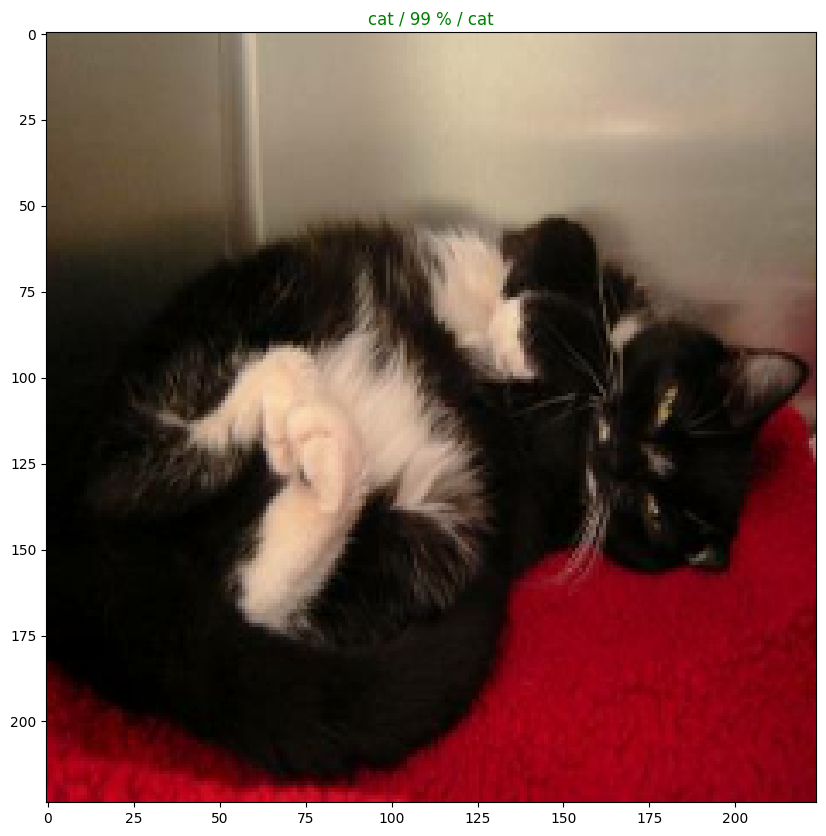

In [100]:
image_comparinger(n=2)

In [217]:
path,file_list=pather(is_test=True)

In [222]:
len(file_list)

12500

In [218]:

breeds=[]
for f in os.listdir(path):
    breeds.append(f[:3])
boolean_label=pd.get_dummies(breeds).to_numpy()
path,file_list=pather(is_test=True)

In [223]:
test_data=image_processes().image_batcher(file_list,boolean_label,is_test=True)

Creting test batch


In [224]:

model_pred_y=model.predict(test_data)

391/391 [==============================] - 22s 55ms/step


In [225]:
model_pred_y=np.array(model_pred_y)
len(model_pred_y)

12500

In [226]:
values=[]
iloc= []
for i in range(len(model_pred_y)):
    values.append(np.argmax(model_pred_y[i]))
    iloc.append(i+1)
    

In [227]:
np.array(iloc)[0]

1

In [228]:
np.array(values)[0]

1

In [229]:
general_data=pd.DataFrame(np.array(iloc),columns=["id"])
general_data["label"]=np.array(values)

In [231]:
general_data

,id,label
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1
...,...,...
12495,12496,0
12496,12497,1
12497,12498,1
12498,12499,0


In [232]:
general_data.to_csv("C:/Users/bahaa/OneDrive/Masaüstü/dog_vs_cat_competition/dogs-vs-cat/general_test_csv_to_kaggle.csv",index=False)